# Analysis of ascertainment strategies/biases

In [1]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)

source("../R/utils.R")

})

In [2]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

## Calculate "direct" estimate of Nea. ancestry (on admixture array sites)

In [3]:
suppressMessages(
array_snps <- load_dataset("../clean_data/ice_age.tsv",
                           "../clean_data/sgdp.tsv",
                           "../clean_data/archaics.tsv",
                           filter_damage=TRUE,
                           random_sample=TRUE)
)

# list of samples with different library prep
non_udg_samples <- c("") #c("AfontovaGora3", "Kotias", "Oase1", "Satsurblia", "Villabruna")

direct_nea <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { mean(ind, na.rm=TRUE) / 2 }) %>%
    gather(name, alpha) %>%
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(alpha=mean(alpha)) %>%
    mutate(method="direct")

Warning message:
“Unknown variables: ``”

In [4]:
snp_counts_direct <- select(array_snps, -c(chrom, pos, ref, alt, contains("archaic"), one_of(non_udg_samples))) %>%
    summarise_all(function(ind) { sum(!is.na(ind)) }) %>% 
    gather(name, snp_count) %>% 
    mutate(name=fix_name(name)) %>%
    group_by(name) %>%
    summarise(snp_count=as.integer(mean(snp_count)))

Warning message:
“Unknown variables: ``”

In [6]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

### Generate a table of SNPs to filter out (transitions)

In [7]:
read_fwf(SNP_FILE,
         fwf_widths(c(20, 6, 16, 16, 2, 2),
                    col_names=c("id", "chrom", "gen", "pos", "alt", "ref")),
         progress=FALSE) %>%
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


### Using all sites

In [7]:
all_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="all", stat="african")
all_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")
all_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")
all_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT) %>% mutate(set="all", stat="nea")

### Using the big Yoruba sites only

In [8]:
EIGENSTRAT_BIG_YRI <- paste0(EIGENSTRAT, "_bigYRI")

In [9]:
subset_sites(prefix=EIGENSTRAT, out_prefix=EIGENSTRAT_BIG_YRI, bed_file="../raw_data/coordinates/big_yoruba.bed")

In [10]:
bigYRI_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                           prefix=EIGENSTRAT_BIG_YRI,
                           ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="bigYRI", stat="african")
bigYRI_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI", stat="nea")
bigYRI_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI", stat="nea")
bigYRI_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_BIG_YRI) %>% mutate(set="bigYRI", stat="nea")

### Using the HO subset only

In [11]:
EIGENSTRAT_HO <- paste0(EIGENSTRAT, "_HO")

In [12]:
subset_sites(prefix=EIGENSTRAT,
             out_prefix=EIGENSTRAT_HO,
             bed_file="../raw_data/coordinates/big_yoruba.bed",
             complement=TRUE)

In [13]:
HO_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT_HO,
                       ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="HO", stat="african")
HO_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")
HO_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")
HO_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_HO) %>% mutate(set="HO", stat="nea")

### Using random 1M subset

In [177]:
read_table2("../raw_data/coordinates/2.2M.bed", col_types="cii", col_names=c("chrom", "start", "end")) %>%
    sample_n(1e6) %>%
    write_tsv("../raw_data/coordinates/1M_subset.bed", col_names=FALSE)

In [178]:
EIGENSTRAT_RND <- paste0(EIGENSTRAT, "_RND")

In [179]:
subset_sites(prefix=EIGENSTRAT, out_prefix=EIGENSTRAT_RND, bed_file="../raw_data/coordinates/1M_subset.bed")

In [180]:
RND_iceage <- qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                       prefix=EIGENSTRAT_RND,
                       ind=paste0(IND_FILE, ".IceAge")) %>% mutate(set="RND", stat="african")
RND_mbuti  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="RND", stat="nea")
RND_yoruba <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Yoruba", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="RND", stat="nea")
RND_dinka  <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp", prefix=EIGENSTRAT_RND) %>% mutate(set="RND", stat="nea")

## Comparison between ascertainment strategies

In [292]:
all_res <- bind_rows(
    bind_rows(all_iceage, all_mbuti),
    bind_rows(bigYRI_iceage, bigYRI_mbuti),
    bind_rows(HO_iceage, HO_mbuti),
    bind_rows(RND_iceage, RND_mbuti)
) %>%
    select(-A, -B, -C, -O, -stderr, -setup) %>%
    inner_join(samples, by=c("X"="name"))

In [293]:
library(GGally)

compare_arrays <- function(df, s, p=NULL, Z=3, xlim=c(0, 0.06), ylim=c(0, 0.06), ...) {
    if (is.null(p)) p <- unique(all_res$pop)
    filter(df, abs(Zscore) > Z) %>%
    select(-Zscore) %>%
    filter(stat == s) %>%
    spread(set, alpha) %>%
    filter(pop %in% p) %>% 
    select(-X, -stat, -age, -pop) %>% 
    pairs(xlim=xlim, ylim=ylim, ...)
#    { ggfacet(., aes(color=pop),
#              columnsX=c("all", "bigYRI", "HO"),
#              columnsY=c("all", "bigYRI", "HO"), fn="smooth_lm") +
#     coord_cartesian(xlim=c(0, 0.05), ylim=c(0, 0.05)) +
#     theme(legend.position="bottom")}
}

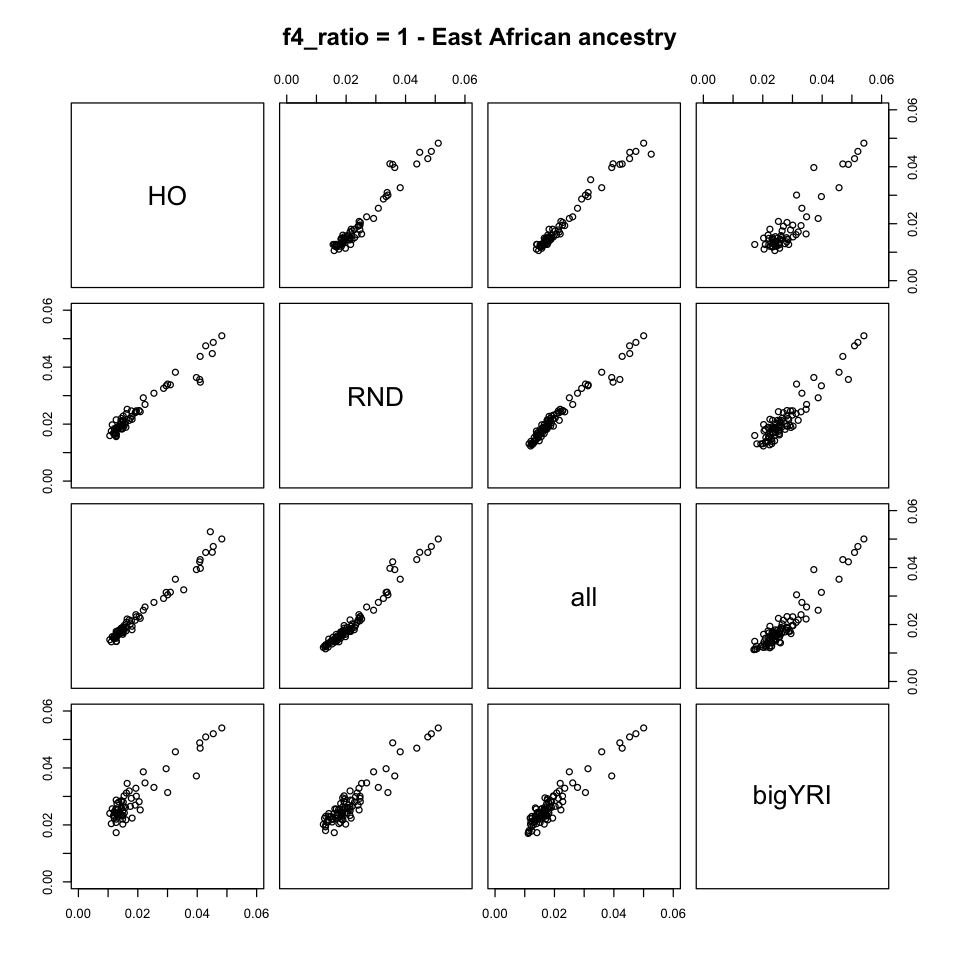

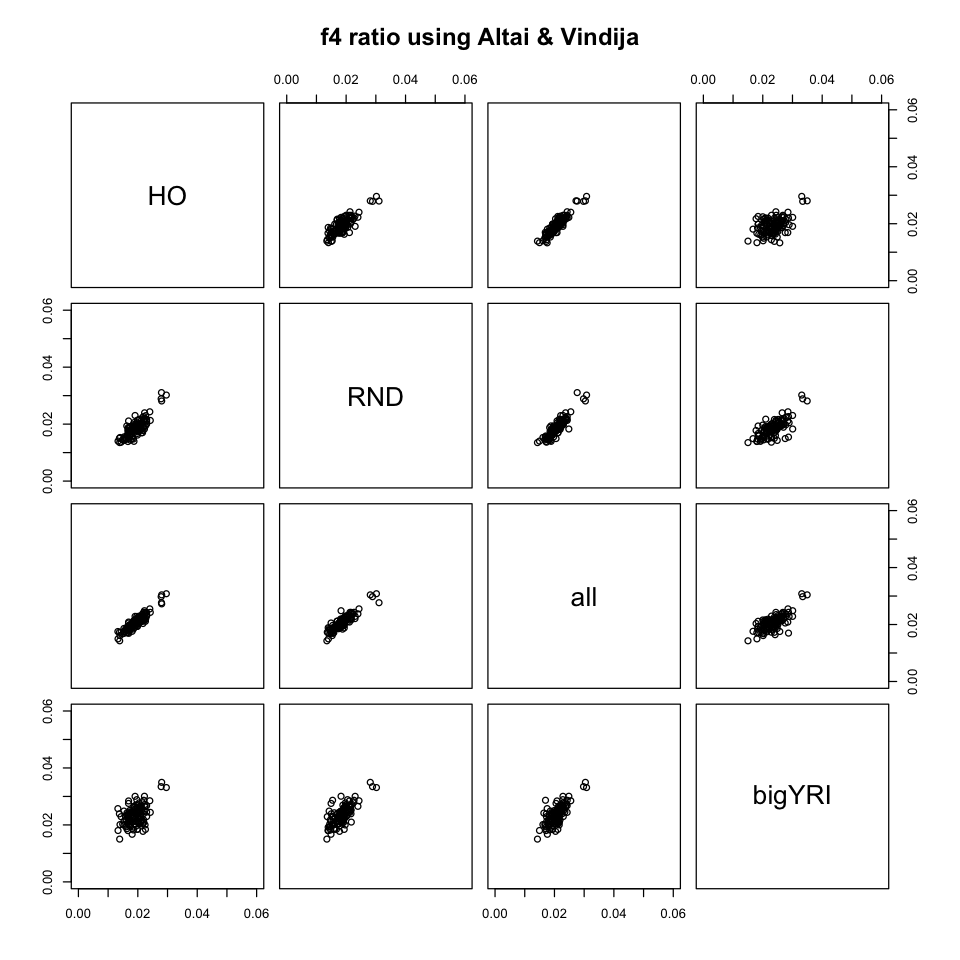

In [265]:
options(repr.plot.width=8, repr.plot.height=8)

all_res %>% compare_arrays(Z=3, "african", main="f4_ratio = 1 - East African ancestry")
all_res %>% compare_arrays(Z=3, "nea", main="f4 ratio using Altai & Vindija")

In [281]:
inner_join(HO_mbuti, samples, by=c("X"="name")) %>% { lm(.[["age"]] ~ .[["alpha"]]) %>% summary}


Call:
lm(formula = .[["age"]] ~ .[["alpha"]])

Residuals:
   Min     1Q Median     3Q    Max 
 -7925  -6431  -5959   4332  38791 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)      3154       2115   1.492    0.138
.[["alpha"]]   161162     100309   1.607    0.110

Residual standard error: 10860 on 156 degrees of freedom
Multiple R-squared:  0.01628,	Adjusted R-squared:  0.009972 
F-statistic: 2.581 on 1 and 156 DF,  p-value: 0.1102


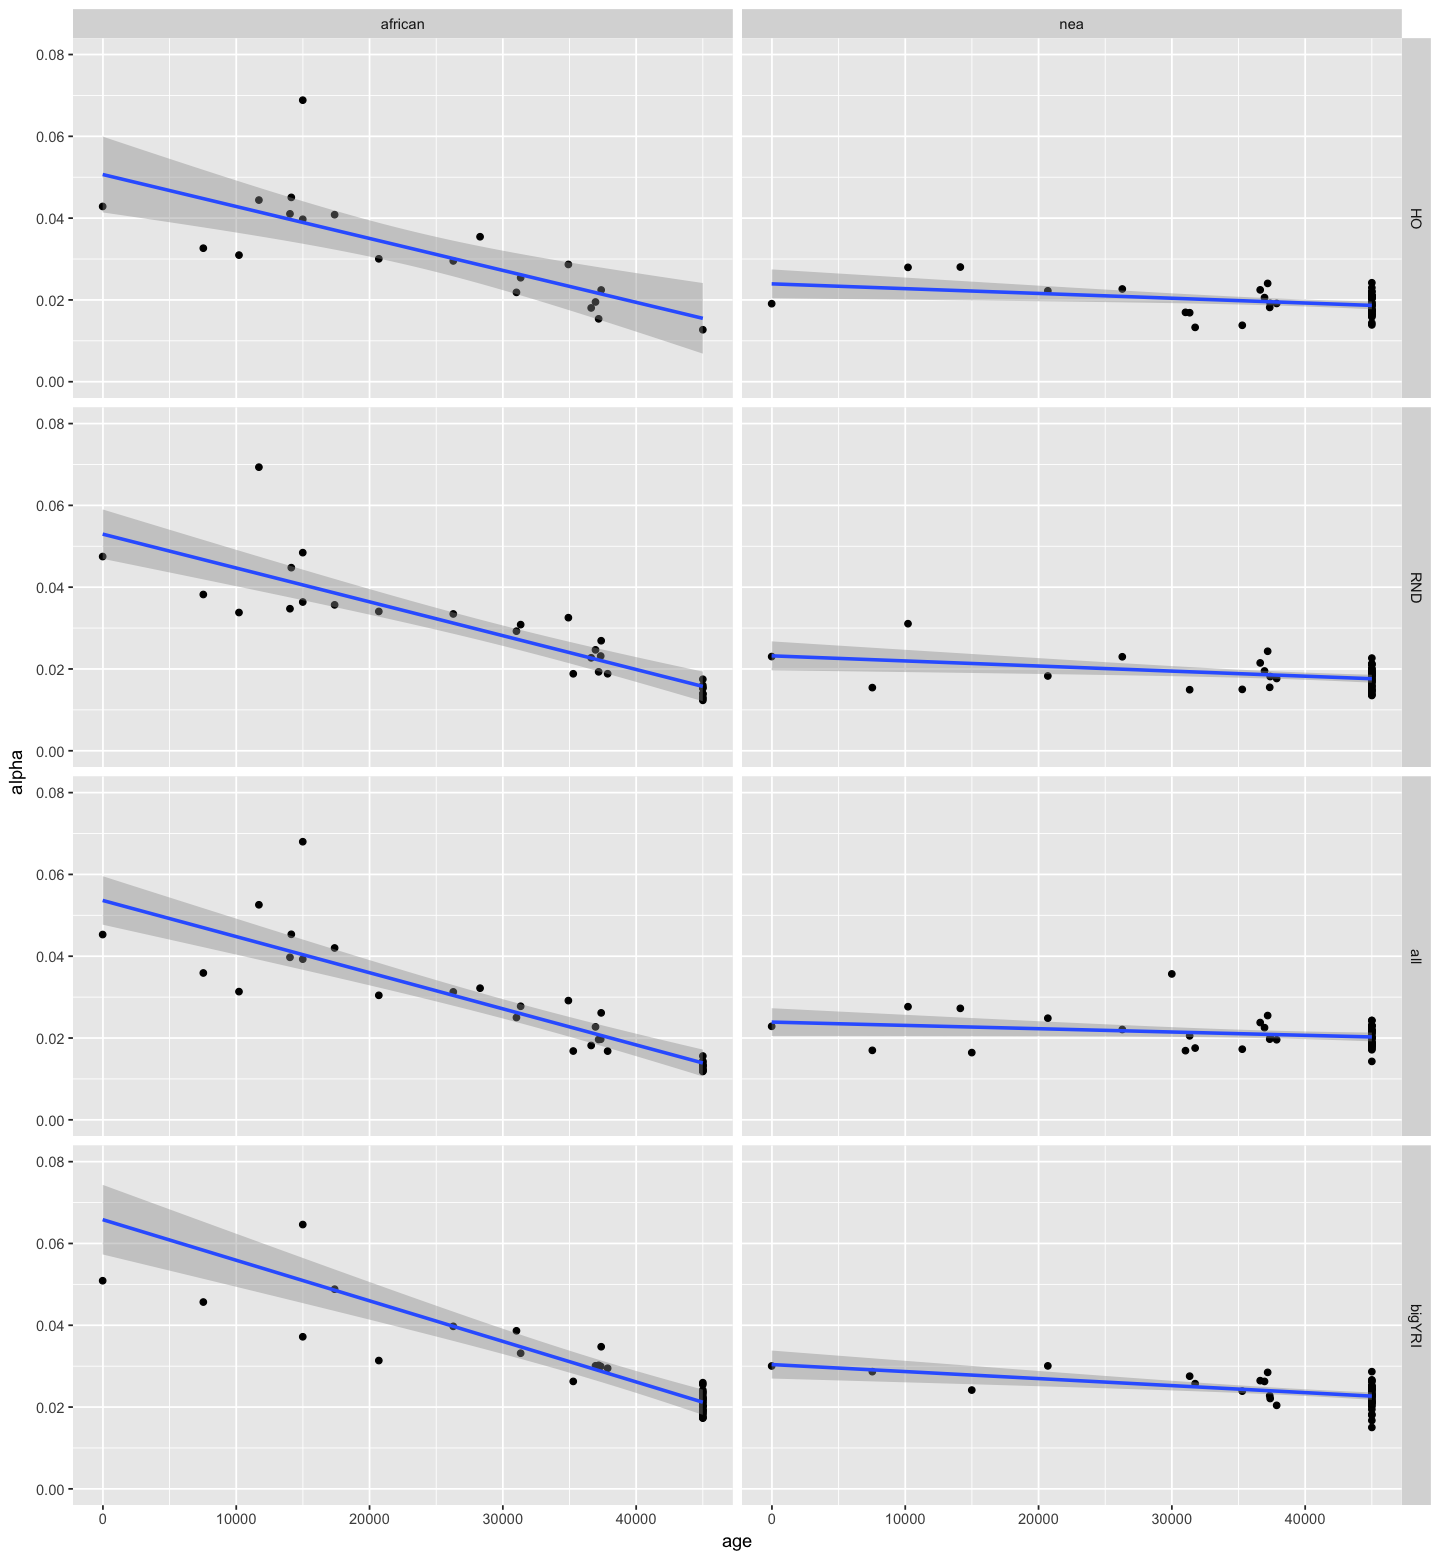

In [294]:
options(repr.plot.width=12, repr.plot.height=13)

filter(all_res, abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(set ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08))

Joining, by = "name"


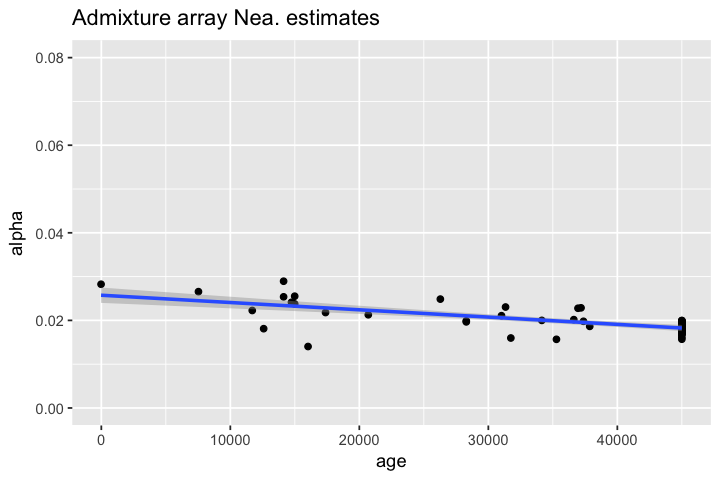

In [257]:
options(repr.plot.width=6, repr.plot.height=4)

inner_join(samples, direct_nea) %>% mutate(age=45000-age) %>% filter(pop %in% c("EMH", "WestEurasia")) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08)) +
    ggtitle("Admixture array Nea. estimates")

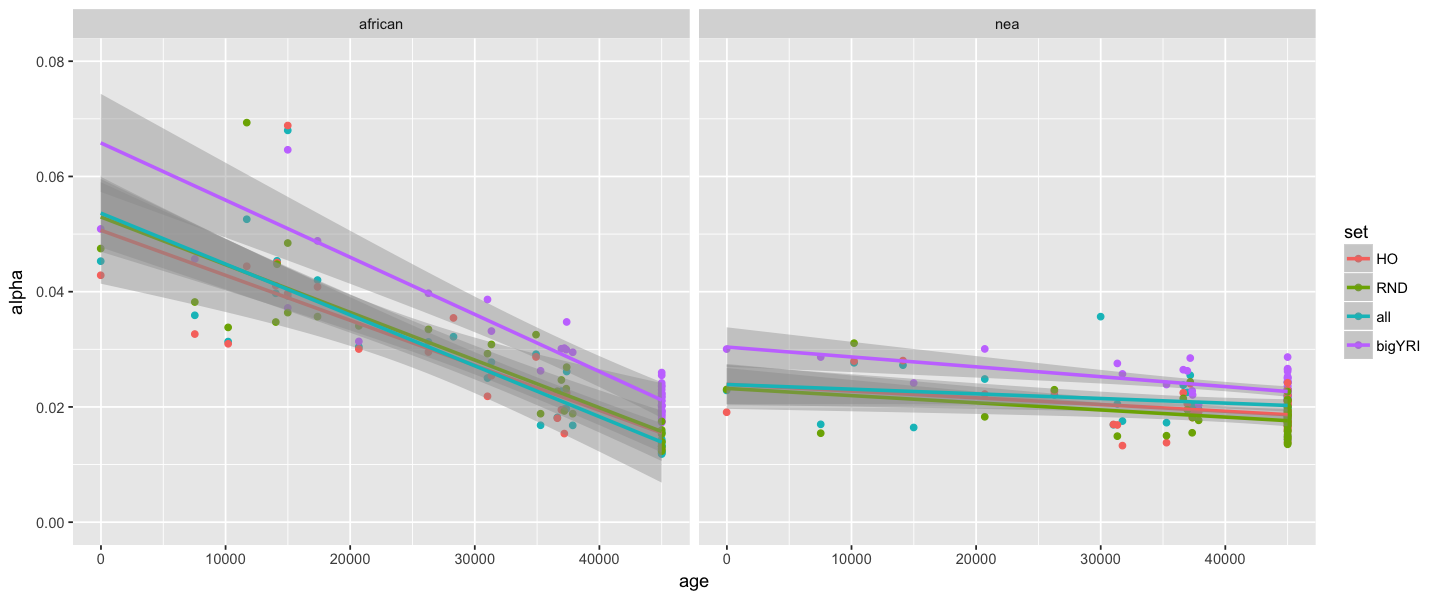

In [258]:
options(repr.plot.width=12, repr.plot.height=5)

filter(all_res, abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha, color=set)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(. ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08))

# Picking apart the Human Origins array

In [74]:
suppressWarnings(suppressMessages({

ho_snps <- read_table2("../raw_data/annotation.hg19.txt", comment="##") %>%
    .[c(ncol(.) - 2, ncol(.) - 1, ncol(.))] %>%
    setNames(c("chrom", "pos", "panel"))

ho_info <- read_table2("ascertainment sample_id panel snps
French          HGDP00521              1        111,970
Han             HGDP00778              2        78,253 
Papuan1         HGDP00542              3        48,531 
San             HGDP01029              4        163,313
Yoruba          HGDP00927              5        124,115
Mbuti           HGDP00456              6        12,162 
Karitiana       HGDP00998              7        2,635  
Sardinian       HGDP00665              8        12,922 
Melanesian      HGDP00491              9        14,988 
Cambodian       HGDP00711              10       16,987 
Mongolian       HGDP01224              11       10,757 
Papuan2         HGDP00551              12       12,117 
Denisova-San    Denisova-HGDP01029     13       151,435")

}))

In [75]:
table(ho_snps$panel)


     1      2      3      4      5      6      7      8      9     10     11 
117194  82163  51265 167504 128738  13094   2885  14261  16236  18358  11773 
    12     13 
 13098 155602 

In [76]:
ho_info

ascertainment,sample_id,panel,snps
French,HGDP00521,1,111970
Han,HGDP00778,2,78253
Papuan1,HGDP00542,3,48531
San,HGDP01029,4,163313
Yoruba,HGDP00927,5,124115
Mbuti,HGDP00456,6,12162
Karitiana,HGDP00998,7,2635
Sardinian,HGDP00665,8,12922
Melanesian,HGDP00491,9,14988
Cambodian,HGDP00711,10,16987


In [77]:
higher_cov <- c("French", "Han", "Papuan1", "San", "Yoruba")

In [83]:
coord_dir <- "../raw_data/coordinates/"

for (pop in ho_info$ascertainment) {
    panel_i <- filter(ho_info, ascertainment == pop)$panel
    
    filter(ho_snps, panel == panel_i) %>%
        arrange(chrom, pos) %>%
        filter(complete.cases(.)) %>%
        mutate(start=as.integer(pos - 1), end=as.integer(pos)) %>%
        select(chrom, start, end) %>%
        write_tsv(file.path(coord_dir, paste0("HO_", pop, ".bed")), col_names=FALSE)
}

In [84]:
for (pop in higher_cov) {
    bed_file <- file.path(coord_dir, paste0("HO_", pop, ".bed"))
    subset_sites(prefix=EIGENSTRAT, out_prefix=paste0(EIGENSTRAT, "_HO_", pop), bed_file=bed_file)
}

In [ ]:
ho_res <- lapply(higher_cov, function(pop) {
    prefix <- paste0(EIGENSTRAT, "_HO_", pop)

    bind_rows(
        qpF4ratio(X=samples$name, A="West_and_Central_Africans", B="Archaics", C="Dinka", O="Chimp",
                  prefix=prefix, ind=paste0(IND_FILE, ".IceAge")) %>% mutate(stat="african"),
        qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=prefix) %>% mutate(stat="nea"),        
    ) %>% mutate(set=pop)
}) %>%
    bind_rows %>%
    select(-A, -B, -C, -O, -stderr, -setup) %>%
    inner_join(samples, by=c("X"="name"))

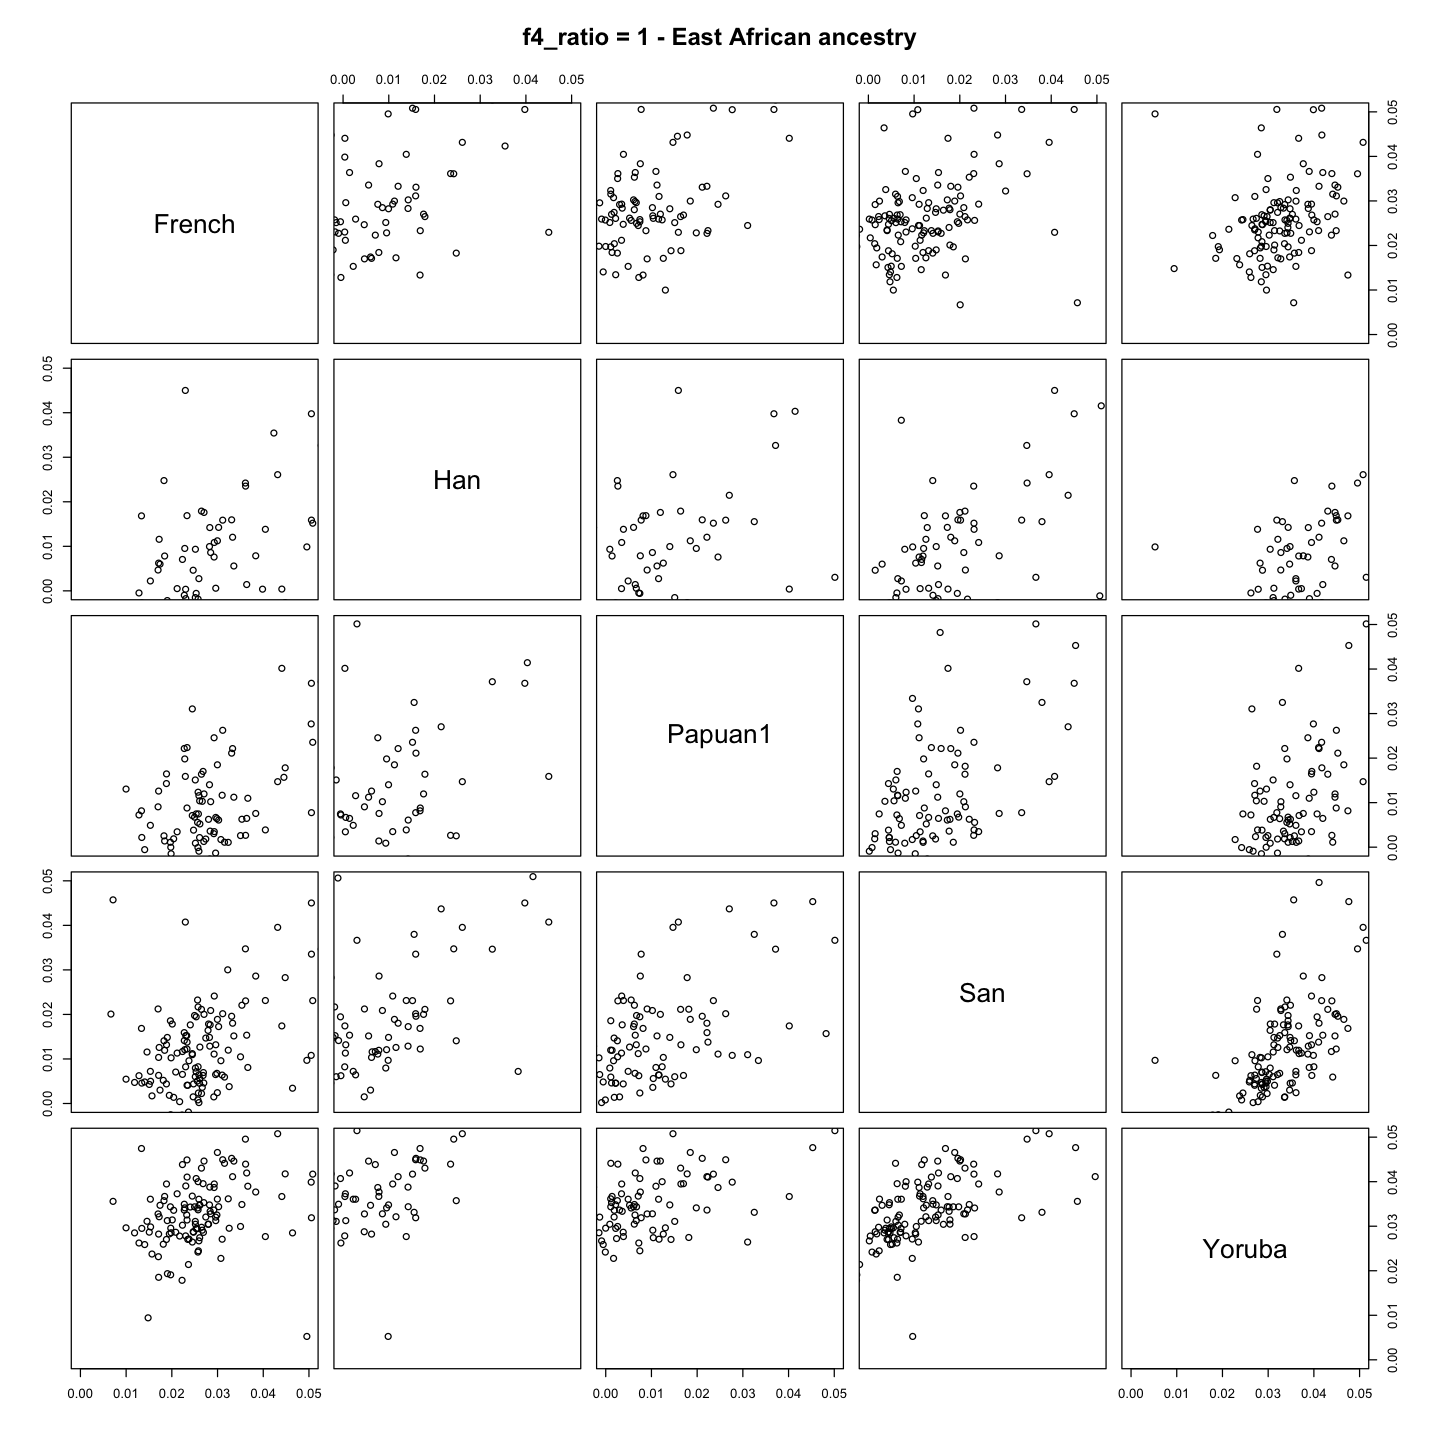

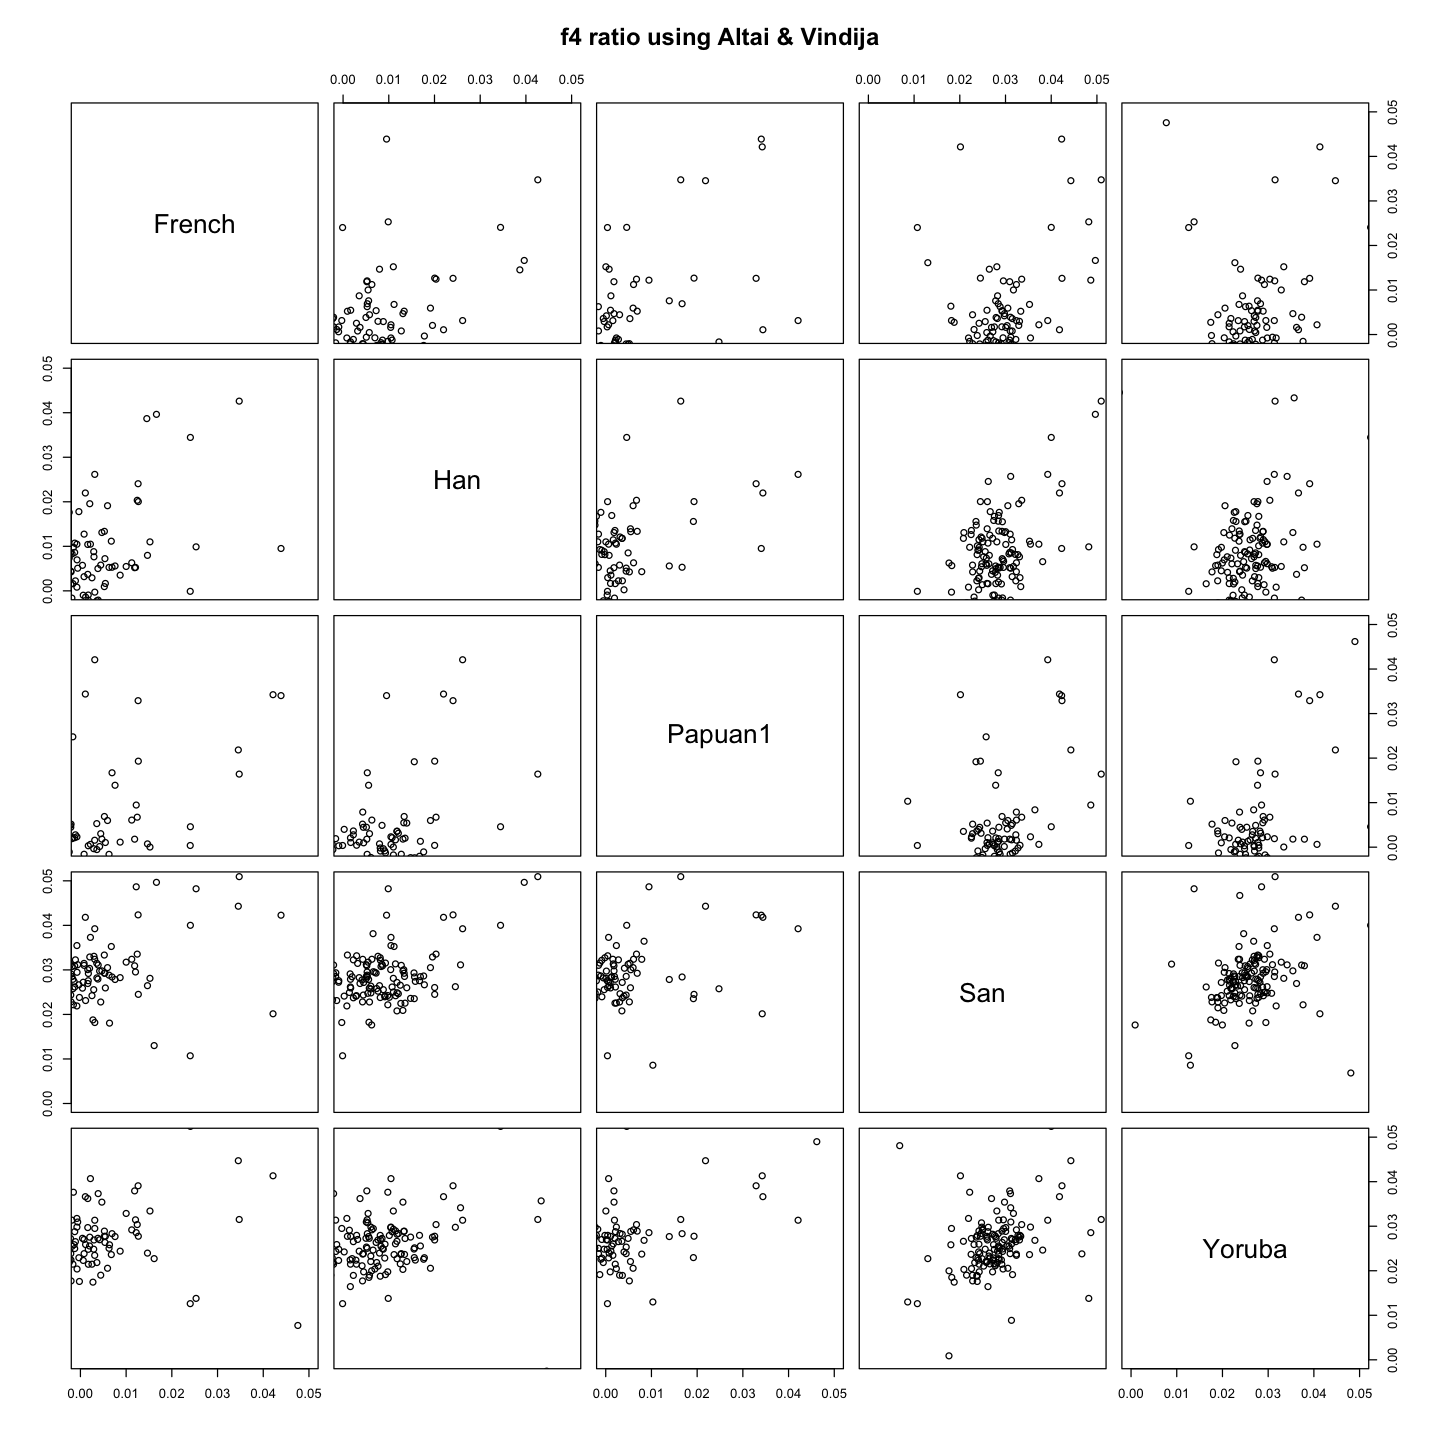

In [268]:
options(repr.plot.width=12, repr.plot.height=12)

ho_res %>% compare_arrays("african", Z=0, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4_ratio = 1 - East African ancestry")
ho_res %>% compare_arrays("nea", Z=0, xlim=c(-0.0, 0.05), ylim=c(-0.0, 0.05), main="f4 ratio using Altai & Vindija")

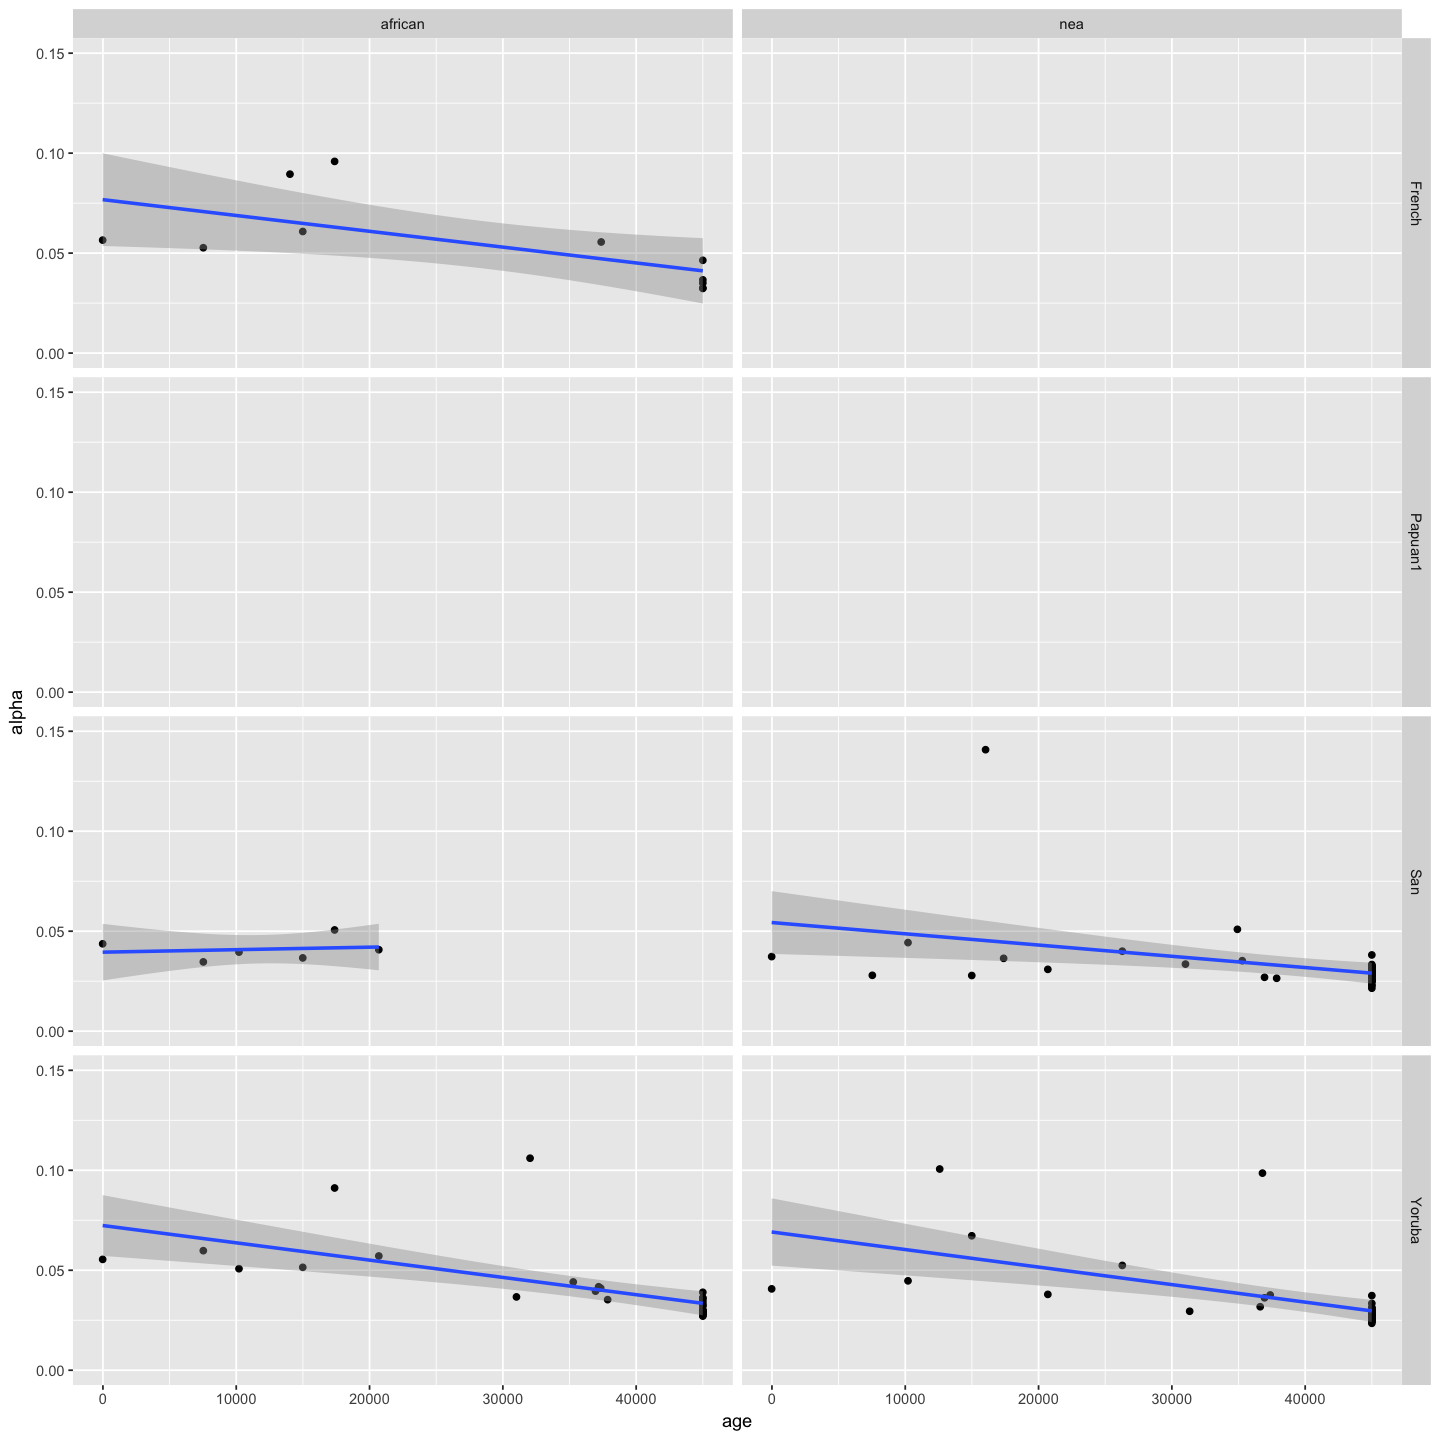

In [288]:
options(repr.plot.width=12, repr.plot.height=12)

ho_res %>% 
filter(abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(set ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(-0.0, 0.15))

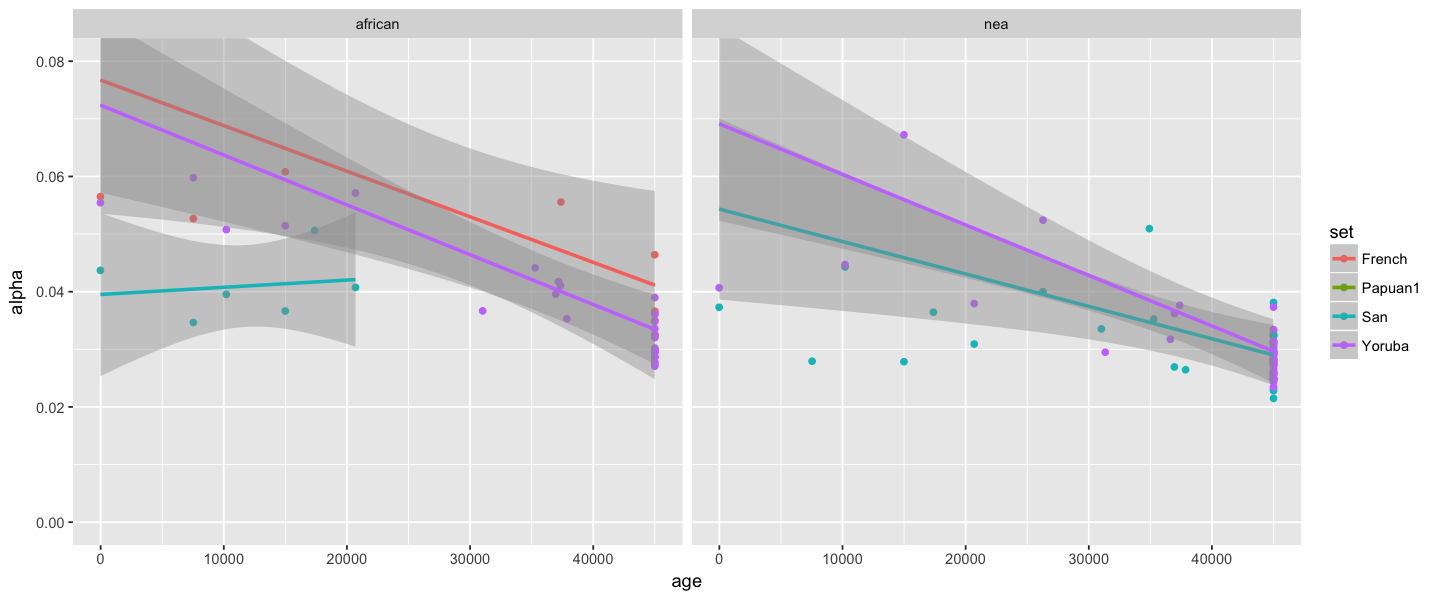

In [164]:
options(repr.plot.width=12, repr.plot.height=5)

ho_res %>% 
filter(abs(Zscore) > 3, pop %in% c("EMH", "WestEurasia")) %>% mutate(age=45000 - age) %>% 
ggplot(aes(age, alpha, color=set)) +
    geom_point() +
    geom_smooth(method="lm") +
    facet_grid(. ~ stat) +
    coord_cartesian(xlim=c(0, 45000), ylim=c(0, 0.08))

In [ ]:
ho_info

# TODO

### Run f3(European, EMH_X_individual, Mbuti)
### Run f4 with Vindija & Altai on the admixture array EIGENSTRAT data
### Split big Yoruba rray into African and Altai part
## calculate f4 on the whole-genome SGDP data

In [270]:
save.image("../RData/admixtools_ascertainment.RData")